In [ ]:
!pip install -q transformers==4.51.3 accelerate==1.7.0 datasets==2.20.0 sqlalchemy==2.0.30 sqlite-utils==3.38 evaluate==0.4.3 peft==0.10.0 trl==0.8.6 bitsandbytes==0.45.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88

In [ ]:
!pip list | grep -E 'bitsandbytes|peft|trl|numpy|transformers|accelerate|datasets|sqlalchemy|sqlite-utils|moz-sql-parser|evaluate|torch|torchvision'

accelerate                            1.7.0
bitsandbytes                          0.45.5
datasets                              2.20.0
evaluate                              0.4.3
fastrlock                             0.8.3
numpy                                 2.0.2
peft                                  0.10.0
sentence-transformers                 4.1.0
sqlite-utils                          3.38
tensorflow-datasets                   4.9.9
torch                                 2.6.0+cu124
torchao                               0.10.0
torchaudio                            2.6.0+cu124
torchdata                             0.11.0
torchsummary                          1.5.1
torchtune                             0.6.1
torchvision                           0.21.0+cu124
transformers                          4.51.3
trl                                   0.8.6
vega-datasets                         0.9.0


In [ ]:
%%bash
python - <<'PY'
import random, numpy as np, torch, os
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
print("Seeds fixed to", SEED)
PY


Seeds fixed to 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json

json_path = '/content/drive/MyDrive/John-Chichewa/crop_questions_with_sql_and_responses.json'


# Read as separate JSON objects
chichewa_val = []
with open(json_path, 'r', encoding='utf-8') as f:
    for line in f:
        chichewa_val.append(json.loads(line))

chichewa_val[0]

{'Question_EN': 'Which district produced the most Macademia in the 2023-2024 season?',
 'Question_NY': 'Ndi boma lanji yomwe  idakolola magede ochuluka mu chaka ya 2023 2024?',
 'SQL': "SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",
 'database_name': 'food_agriculture',
 'SQL_Response': 'Mangochi (4998.0)'}

In [ ]:
len(chichewa_val)

31

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from huggingface_hub import login

# Login to Hugging Face Hub
# login() 


In [ ]:
# reflect every .sqlite file to create a plain-text schema description
from pathlib import Path
import sqlalchemy as sa

DB_ROOT = Path("/content/drive/MyDrive/John-Chichewa")

_schema_cache: dict[str, str] = {}            # {db_id: "…schema string…"}

def get_schema_string(db_id: str) -> str:
    """Return a compact textual schema for the given Spider database."""
    if db_id in _schema_cache:
        return _schema_cache[db_id]

    db_file = DB_ROOT / f"{db_id}.sqlite"
    engine  = sa.create_engine(f"sqlite:///{db_file}")
    insp    = sa.inspect(engine)

    parts   = []
    for tbl in sorted(insp.get_table_names()):
        cols = [c["name"] for c in insp.get_columns(tbl)]
        parts.append(f"{tbl}({', '.join(cols)})")

    schema_str = ", ".join(parts)
    _schema_cache[db_id] = schema_str
    return schema_str

In [ ]:
schema = get_schema_string(chichewa_val[5]["database_name"])
print(schema)

food_insecurity(district, analyzed_population, time_period, percentage_population, insecurity_level, insecurity_desc_short, insecurity_desc_long), prices(ADD_Name, EPA_Name, District, Market, Month_Name, Yr, Commodity, Price, Collection_Date), production(District, Crop, Yield, Season)


# Evaluation Metrics

In [ ]:
import re
_ws   = re.compile(r"\s+")
_comm = re.compile(r"\s*,\s*")          # blank(s) ↔ comma ↔ blank(s)

def exact_match(pred: str, gold: str) -> bool:
    def norm(s: str) -> str:
        s = s.strip().lower()
        s = _ws.sub(" ", s)             # collapse runs of whitespace
        s = _comm.sub(", ", s)          # canonical “comma␣”
        return s
    return norm(pred) == norm(gold)


from sqlglot import parse_one, expressions

def flatten_ast(node):
    """
    Recursively collect all node‐type names and literal values as lowercase strings.
    """
    out = set()

    def walk(n):
        # record the AST node type
        out.add(type(n).__name__.lower())

        # record any literal (e.g. identifiers, strings, numbers)
        if hasattr(n, "this") and isinstance(n.this, (str, int, float)):
            out.add(str(n.this).lower())

        # recurse into child expressions
        for arg in n.args.values():
            if isinstance(arg, list):
                for child in arg:
                    if isinstance(child, expressions.Expression):
                        walk(child)
            elif isinstance(arg, expressions.Expression):
                walk(arg)

    walk(node)
    return out

def component_match(pred_sql, gold_sql):
    try:
        pred_ast = parse_one(pred_sql)
        gold_ast = parse_one(gold_sql)
    except Exception:
        return 0.0

    pred_set = flatten_ast(pred_ast)
    gold_set = flatten_ast(gold_ast)
    if not gold_set:
        return 0.0
    return len(pred_set & gold_set) / len(gold_set)


import sqlite3, pandas as pd, numpy as np
from tqdm import tqdm

def run_query(sql: str, db_path: Path):
    """Return query result as a sorted list of tuples (order-independent)."""
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(sql, conn)
        # sort rows + cols for order-invariant comparison
        return tuple(map(tuple, df.sort_index(axis=1).sort_values(list(df.columns)).to_numpy()))
    except Exception as e:
        # any failure counts as wrong
        return f"ERROR-{e}"

def execution_accuracy(dataset):
    """Compute Spider-style Execution Accuracy on a HF split (e.g. validation)."""
    correct = 0
    for ex in tqdm(dataset, desc="Evaluating"):
        db_id   = ex["db_id"]
        schema  = get_schema_string(db_id)
        pred_sql= generate_sql(ex["question"], schema)

        db_file = DB_ROOT / db_id / f"{db_id}.sqlite"
        gold    = run_query(ex["query"],     db_file)
        pred    = run_query(pred_sql,        db_file)

        if gold == pred:
            correct += 1

    return correct / len(dataset)

# Zero-Shot Chichewa2SQL

In [ ]:
def build_zero_shot_prompt(q_chi: str, schema_str: str) -> str:
    """
    Return a single-shot prompt:
    • instructs the model (in English) to answer in SQL
    • supplies the DB schema in plain text
    • gives the Chichewa question as-is
    """
    return f"""
### Instruction:
You are an expert SQL engineer who also understands Chichewa.
Given the database schema and a question written in Chichewa, write ONE
valid SQL query that answers the question.  Output ONLY the SQL statement
and end it with a semicolon.

### Database Schema:
{schema_str}

### Chichewa Question:
{q_chi}

### SQL:
""".lstrip()



In [ ]:
# Imports

from pathlib import Path
import torch, re, gc
import pandas as pd
from tqdm.auto import tqdm
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          AutoModelForSeq2SeqLM, BitsAndBytesConfig)
import warnings
from transformers import logging
import random

logging.set_verbosity_error()
warnings.filterwarnings('ignore')

# global seed (reproducible shuffles, torch, numpy, random, etc.)

import random, numpy as np, torch, os
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


# Model registry  (add / remove as you wish)

MODELS = {
    "mistral_7b_base"              : "mistralai/Mistral-7B-v0.3",
    "mistral_7b_instruct"          : "mistralai/Mistral-7B-Instruct-v0.3",
    "llama3_8b_base"               : "meta-llama/Llama-3.1-8B",
    "llama3_8b_instruct"           : "meta-llama/Llama-3.1-8B-Instruct",
    "deepseek_coder_6.7b_base"     : "deepseek-ai/deepseek-coder-6.7b-base",
    "deepseek_coder_6.7b_instruct" : "deepseek-ai/deepseek-coder-6.7b-instruct",
    "sqlcoder_7b"                  : "defog/sqlcoder-7b-2",
    "codellama_7b_instruct"        : "codellama/CodeLlama-7b-Instruct-hf",
    "bloom_7b"                     : "bigscience/bloomz-7b1-mt"
}

# optional: load everything in 4-bit to fit even more easily
bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")

# Evaluation loop

results = []

for nick, ckpt in MODELS.items():
    print(f"\n=== Loading {nick} ===")
    tok = AutoTokenizer.from_pretrained(ckpt, trust_remote_code=True)

    lm  = AutoModelForCausalLM.from_pretrained(
            ckpt,
            device_map="auto",
            torch_dtype=torch.float16,
            quantization_config=bnb_cfg,          # <-- comment out for fp16
            trust_remote_code=True
          ).eval()


    _fence  = re.compile(r"```.*?```", re.S)
    _select = re.compile(r"\bselect\b", re.I)

    def generate_sql(ch_q, schema):
        """Zero-shot Chichewa → SQL using the current model."""
        prompt = build_zero_shot_prompt(ch_q, schema)
        with torch.no_grad():
            ids = lm.generate(
                **tok(prompt, return_tensors="pt").to(lm.device),
                max_new_tokens=128,
                do_sample=False,
                eos_token_id=tok.eos_token_id,
                pad_token_id=tok.eos_token_id
            )
        txt = tok.decode(ids[0], skip_special_tokens=True)
        txt = _fence.sub("", txt)
        sel = _select.search(txt)
        if not sel:
            return txt.strip()
        frag = txt[sel.start():]
        semi = frag.find(";")
        return " ".join(frag[:semi+1].split()) if semi != -1 else " ".join(frag.split())

    # ── metric accumulators ───────────────────────────────────
    em_list, cm_list = [], []
    ea_hits = 0

    for ex in tqdm(chichewa_val, desc=f"Evaluating {nick}"):
        db_id   = ex["database_name"]
        schema  = get_schema_string(db_id)
        pred_sql= generate_sql(ex["Question_NY"], schema)

        # Exact / Component
        em_list.append(exact_match(pred_sql, ex["SQL"]))
        cm_list.append(component_match(pred_sql, ex["SQL"]))

        # Execution accuracy
        db_path = DB_ROOT / f"{db_id}.sqlite"
        gold = run_query(ex["SQL"],  db_path)
        pred = run_query(pred_sql,   db_path)
        ea_hits += int(gold == pred)

    # collect aggregates
    N = len(chichewa_val)
    results.append({
        "model"   : nick,
        "EM"      : sum(em_list) / N,
        "CM"      : sum(cm_list) / N,
        "EX"      : ea_hits / N
    })

    # free GPU before next model
    del lm; del tok
    torch.cuda.empty_cache(); gc.collect()



In [ ]:
# choose an example

idx        = 0                               # <-- change if you want another row
example    = chichewa_val[idx]
chi_q      = example["Question_NY"]
eng_q_ds   = example["Question_EN"]          # English from dataset
gold_sql   = example["SQL"]
db_id      = example["database_name"]
schema_one = get_schema_string(db_id)
db_file_one= DB_ROOT / f"{db_id}.sqlite"

print(f"Example {idx}  |  DB = {db_id}")

#  helper to load a model & generate SQL

import re, gc, torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
_fence  = re.compile(r"```.*?```", re.S)
_select = re.compile(r"\bselect\b", re.I)
bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")

def load_llm(ckpt:str):
    tok = AutoTokenizer.from_pretrained(ckpt, trust_remote_code=True)
    lm  = AutoModelForCausalLM.from_pretrained(
            ckpt,
            device_map="auto",
            torch_dtype=torch.float16,
            quantization_config=bnb_cfg,
            trust_remote_code=True).eval()
    return tok, lm

def generate_sql(tok, lm, q_chi, schema):
    prompt = build_zero_shot_prompt(q_chi, schema)
    ids = lm.generate(**tok(prompt, return_tensors="pt").to(lm.device),
                      max_new_tokens=128, do_sample=False,
                      eos_token_id=tok.eos_token_id,
                      pad_token_id=tok.eos_token_id)
    txt = tok.decode(ids[0], skip_special_tokens=True)
    txt = _fence.sub("", txt)
    m   = _select.search(txt)
    sql = txt[m.start():] if m else txt
    sql = sql.split(";")[0].replace("\n", " ").strip() + ";"
    return sql

# run every model on the single example

rows = []
for nick, ckpt in MODELS.items():
    print(f" ▸ {nick}")
    tok, lm = load_llm(ckpt)

    pred_sql = generate_sql(tok, lm, chi_q, schema_one)

    em = exact_match(pred_sql, gold_sql)
    cm = round(component_match(pred_sql, gold_sql), 3)
    ea = run_query(pred_sql, db_file_one) == run_query(gold_sql, db_file_one)

    rows.append({
        "model"              : nick,
        "Chichewa Q"         : chi_q,
        "Dataset EN Q"       : eng_q_ds,
        "Gold SQL"           : gold_sql,
        "Predicted SQL"      : pred_sql,
        "EM"                 : em,
        "CM"                 : cm,
        "EX"                 : ea
    })

    del tok, lm
    torch.cuda.empty_cache(); gc.collect()


Example 0  |  DB = food_agriculture
 ▸ mistral_7b_base


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

 ▸ mistral_7b_instruct


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

 ▸ llama3_8b_base


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

 ▸ llama3_8b_instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

 ▸ deepseek_coder_6.7b_base


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 ▸ deepseek_coder_6.7b_instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 ▸ sqlcoder_7b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

 ▸ codellama_7b_instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 ▸ bloom_7b


In [ ]:
# show one example

import pandas as pd
pd.set_option("display.max_colwidth", None)
df_one_chi = pd.DataFrame(rows).set_index("model")
print("\n── Single-example comparison ──")

df_one_chi


── Single-example comparison ──


,Chichewa Q,Dataset EN Q,Gold SQL,Predicted SQL,EM,CM,EX
model,,,,,,,
mistral_7b_base,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';","SELECT District, Crop, Yield, Season FROM production WHERE District IN (SELECT District FROM food_insecurity WHERE analyzed_population = 10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000;",False,0.000,False
mistral_7b_instruct,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT District FROM food_insecurity WHERE time_period BETWEEN '2023' AND '2024';,False,0.421,False
llama3_8b_base,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT * FROM food_insecurity WHERE time_period = '2023 2024';,False,0.421,False
llama3_8b_instruct,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT DISTINCT district FROM production WHERE season = '2023 2024';,False,0.579,False
deepseek_coder_6.7b_base,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT * FROM food_insecurity WHERE time_period = '2023-2024' AND insecurity_level = 'High' AND analyzed_population > 1000000;,False,0.526,False
deepseek_coder_6.7b_instruct,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';","SELECT prices.ADD_Name, prices.EPA_Name, prices.District, prices.Market, prices.Month_Name, prices.Yr, prices.Commodity, prices.Price, prices.Collection_Date FROM prices WHERE prices.Yr BETWEEN 2023 AND 2024;",False,0.421,False
sqlcoder_7b,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';","SELECT p.district, p.market, p.month_name, p.yr, p.commodity, p.price, p.collection_date FROM prices p WHERE p.district = 'District 1' AND p.market = 'Market 1' AND p.month_name = 'January' AND p.yr BETWEEN 2023 AND 2024;",False,0.526,False
codellama_7b_instruct,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT DISTINCT District FROM food_insecurity WHERE time_period = '2023-2024' AND insecurity_level = 'High' AND analyzed_population = 'All' AND district IS NOT NULL;,False,0.579,False
bloom_7b,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';","SELECT district, analyzed_population, time_period, percentage_population, insecurity_level, insecurity_desc_short, insecurity_desc_long FROM food_insecurity WHERE district = 'N' AND analyzed_population = '100

In [ ]:
# Display model performance in a table

df_all_chi = pd.DataFrame(results).set_index("model").round(3)
print("\n=== Zero-shot Chichewa → SQL performance ===")

df_all_chi



=== Zero-shot Chichewa → SQL performance ===


,EM,CM,EA
model,,,
mistral_7b_base,0.0,0.595,0.032
mistral_7b_instruct,0.0,0.595,0.032
llama3_8b_base,0.0,0.631,0.032
llama3_8b_instruct,0.0,0.620,0.032
deepseek_coder_6.7b_base,0.0,0.511,0.032
deepseek_coder_6.7b_instruct,0.0,0.498,0.032
sqlcoder_7b,0.0,0.529,0.032
codellama_7b_instruct,0.0,0.586,0.032
bloom_7b,0.0,0.559,0.032


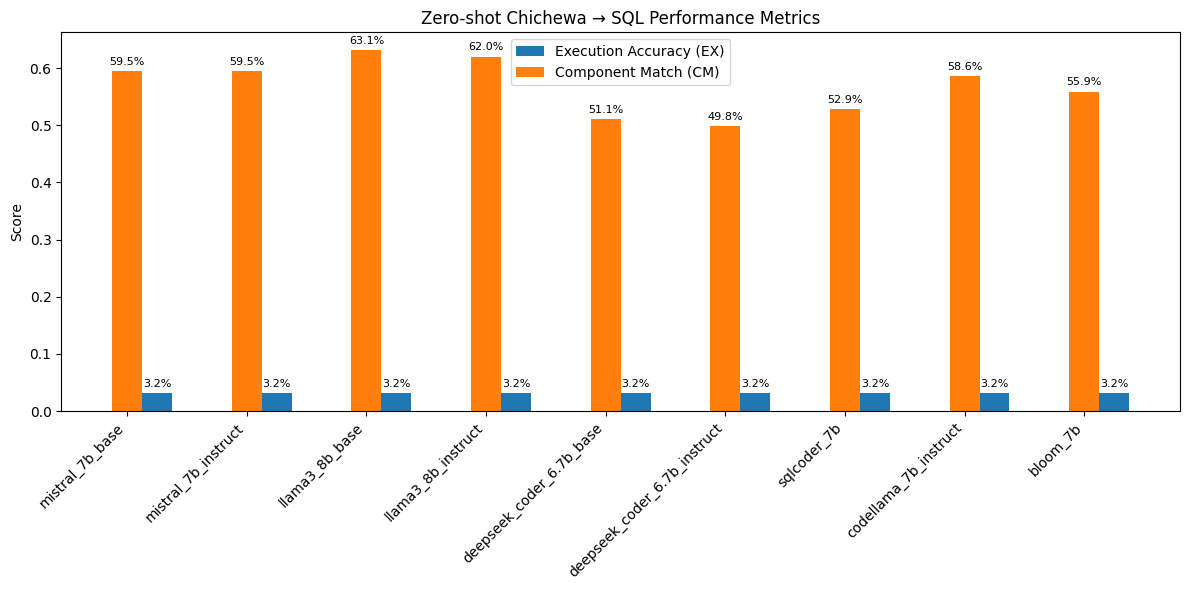

In [ ]:
import matplotlib.pyplot as plt

cm = list(df_all_chi.CM.values) #[0.595, 0.595, 0.631, 0.620, 0.511, 0.498, 0.529, 0.586, 0.559]
ea = list(df_all_chi.EX.values) #[0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032]

x = range(len(MODELS))
width = 0.25

plt.figure(figsize=(12, 6))

bars_ea = plt.bar([p + width for p in x], ea, width=width, label="Execution Accuracy (EX)")
bars_cm = plt.bar(x, cm, width=width, label="Component Match (CM)",)

plt.xticks(x, MODELS, rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Zero-shot Chichewa → SQL Performance Metrics")
plt.legend()

def add_percentage_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height * 100:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8)

add_percentage_labels(bars_cm)
add_percentage_labels(bars_ea)

plt.tight_layout()
plt.show()


# Zero-Shot EnglishTranslations2SQL

In [ ]:
# NLLB-200-3.3 B translator (fp16, full weights)

from transformers import pipeline, BitsAndBytesConfig
import warnings
from transformers import logging
import random

logging.set_verbosity_error()
warnings.filterwarnings('ignore')

# global seed (reproducible shuffles, torch, numpy, random, etc.)

import random, numpy as np, torch, os
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


CHI, ENG = "nya_Latn", "eng_Latn"
translator = pipeline(
    "translation",
    model="facebook/nllb-200-3.3B",
    src_lang=CHI, tgt_lang=ENG,
    #device_map="auto",
    #torch_dtype="auto",          # fp16
    device=-1                                     # CPU
)

def translate_to_en(q_chi, max_len=128):
    return translator(q_chi, max_length=max_len)[0]["translation_text"].strip()

for ex in chichewa_val:
    ex["EN_generated"] = translate_to_en(ex["Question_NY"])

del translator             # free CPU & any stray GPU tensors
torch.cuda.empty_cache()


# 2 ▪ English zero-shot prompt (same text, just “English Q”)

def build_zero_shot_prompt_EN(q_en: str, schema: str) -> str:
    return f"""### Instruction:
You are an expert SQL engineer. Using the database schema and the translated English
question, write ONE valid SQL query that answers the question.  Output ONLY
the SQL and end it with a semicolon.

### Database Schema:
{schema}

### English Question:
{q_en}

### SQL:
"""

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/6.93G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/8.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

In [ ]:
import warnings
from transformers import logging
import random

logging.set_verbosity_error()
warnings.filterwarnings('ignore')

# 0 ▪ global seed (reproducible shuffles, torch, numpy, random, etc.)

import random, numpy as np, torch, os
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# 3 ▪ small utility: run one model on one (CHI→EN→SQL) example

import torch, re, gc, pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

_fence  = re.compile(r"```.*?```", re.S)
_select = re.compile(r"\bselect\b", re.I)
bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")   # memory-friendly

def load_llm(ckpt):
    tok = AutoTokenizer.from_pretrained(ckpt, trust_remote_code=True)
    lm  = AutoModelForCausalLM.from_pretrained(
            ckpt, device_map="auto",
            torch_dtype=torch.float16,
            quantization_config=bnb_cfg,
            trust_remote_code=True).eval()
    return tok, lm

def gen_sql(tok, lm, q_en, schema):
    prompt = build_zero_shot_prompt_EN(q_en, schema)
    ids = lm.generate(**tok(prompt, return_tensors="pt").to(lm.device),
                      max_new_tokens=128, do_sample=False,
                      eos_token_id=tok.eos_token_id,
                      pad_token_id=tok.eos_token_id)
    txt = tok.decode(ids[0], skip_special_tokens=True)
    txt = _fence.sub("", txt)
    sel = _select.search(txt)
    if not sel:
        return txt.strip()
    frag = txt[sel.start():]
    semi = frag.find(";")
    return " ".join(frag[:semi+1].split()) if semi != -1 else frag.strip()


In [ ]:
import warnings
from transformers import logging
import random

logging.set_verbosity_error()
warnings.filterwarnings('ignore')

# 0 ▪ global seed (reproducible shuffles, torch, numpy, random, etc.)

import random, numpy as np, torch, os
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


# 3.  evaluation loop (unchanged except we read EN_generated)

_fence  = re.compile(r"```.*?```", re.S)
_select = re.compile(r"\bselect\b", re.I)
bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")

def load_llm(ckpt):
    tok = AutoTokenizer.from_pretrained(ckpt, trust_remote_code=True)
    lm  = AutoModelForCausalLM.from_pretrained(
            ckpt,
            device_map="auto",
            torch_dtype=torch.float16,
            quantization_config=bnb_cfg,
            trust_remote_code=True).eval()
    return tok, lm

def gen_sql(tok, lm, q_en, schema):
    prompt = build_zero_shot_prompt_EN(q_en, schema)
    ids = lm.generate(**tok(prompt, return_tensors="pt").to(lm.device),
                      max_new_tokens=128, do_sample=False,
                      eos_token_id=tok.eos_token_id,
                      pad_token_id=tok.eos_token_id)
    txt = tok.decode(ids[0], skip_special_tokens=True)
    txt = _fence.sub("", txt)
    sel = _select.search(txt)
    if not sel:
        return txt.strip()
    frag = txt[sel.start():]
    semi = frag.find(";")
    return " ".join(frag[:semi+1].split()) if semi != -1 else frag.strip()

rows_ex, rows_ds = [], []

# Define variables for the single example
example0 = chichewa_val[0]
schema0 = get_schema_string(example0["database_name"])
gold_sql0 = example0["SQL"]
chiQ0 = example0["Question_NY"]
eng_q_ds0 = example0["Question_EN"]
db0 = DB_ROOT / f"{example0['database_name']}.sqlite"

for nick, ckpt in MODELS.items():
    print(f"→ {nick}")
    tok, lm = load_llm(ckpt)

    # single-example inspection (idx = 0)
    sql_pred = gen_sql(tok, lm,
                       chichewa_val[0]["EN_generated"],
                       schema0)
    em  = exact_match(sql_pred, gold_sql0)
    cm  = component_match(sql_pred, gold_sql0)
    ea  = run_query(sql_pred, db0) == run_query(gold_sql0, db0)

    rows_ex.append({
        "model"          : nick,
        "Chichewa Q"     : chiQ0,
        "Dataset EN Q"   : eng_q_ds0,
        "Generated EN Q" : chichewa_val[0]["EN_generated"],
        "Gold SQL"       : gold_sql0,
        "Predicted SQL"  : sql_pred,
        "EM"             : em,
        "CM"             : round(cm,3),
        "EX"             : ea
    })

    # dataset-wide metrics
    em_tot = cm_tot = ea_tot = 0
    for ex in chichewa_val:
        sql_hat = gen_sql(tok, lm,
                          ex["EN_generated"],
                          get_schema_string(ex["database_name"]))
        em_tot += exact_match(sql_hat, ex["SQL"])
        cm_tot += component_match(sql_hat, ex["SQL"])
        dbf     = DB_ROOT / f"{ex['database_name']}.sqlite"
        ea_tot += run_query(sql_hat, dbf) == run_query(ex["SQL"], dbf)

    N = len(chichewa_val)
    rows_ds.append({"model": nick,
                    "EM": em_tot/N,
                    "CM": cm_tot/N,
                    "EX": ea_tot/N})

    # cleanup
    del tok, lm; torch.cuda.empty_cache(); gc.collect()



→ mistral_7b_base


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

→ mistral_7b_instruct


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

→ llama3_8b_base


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

→ llama3_8b_instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

→ deepseek_coder_6.7b_base


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

→ deepseek_coder_6.7b_instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

→ sqlcoder_7b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

→ codellama_7b_instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

→ bloom_7b


In [ ]:
# 5 ▪ display dataframes

pd.set_option("display.max_colwidth", None)

df_one_trans = pd.DataFrame(rows_ex).set_index("model")
print("\n── Single-example comparison ──")
df_one_trans


── Single-example comparison ──


,Chichewa Q,Dataset EN Q,Generated EN Q,Gold SQL,Predicted SQL,EM,CM,EA
model,,,,,,,,
mistral_7b_base,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,Which state has harvested the most number of mangoes in the year 2023-2024?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';","SELECT\n d.District,\n p.Crop,\n p.Yield\nFROM\n production p\n JOIN food_insecurity f\n ON p.District = f.district\nWHERE\n f.insecurity_desc_short = 'Mango'\n AND p.Season = '2023-2024'\n AND p.Yield > ALL (\n SELECT\n p2.Yield\n FROM\n production p2\n WHERE\n p2.District",False,0.000,False
mistral_7b_instruct,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,Which state has harvested the most number of mangoes in the year 2023-2024?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';","### Instruction:\nYou are an expert SQL engineer. Using the database schema and the English\nquestion, write ONE valid SQL query that answers the question. Output ONLY\nthe SQL and end it with a semicolon.\n\n### Database Schema:\nfood_insecurity(district, analyzed_population, time_period, percentage_population, insecurity_level, insecurity_desc_short, insecurity_desc_long), prices(ADD_Name, EPA_Name, District, Market, Month_Name, Yr, Commodity, Price, Collection_Date), production(District, Crop, Yield, Season)\n\n### English Question:\nWhich state has harvested the most number of mangoes in the year 2023-2024?\n\n### SQL:",False,0.000,False
llama3_8b_base,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,Which state has harvested the most number of mangoes in the year 2023-2024?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT * FROM production WHERE District = 'Karnataka' AND Crop = 'Mango' AND Season = '2023-2024';,False,0.737,False
llama3_8b_instruct,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,Which state has harvested the most number of mangoes in the year 2023-2024?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT District FROM production WHERE Crop ='mangoes' AND Season = '2023-2024' GROUP BY District ORDER BY Yield DESC LIMIT 1;,False,0.789,False
deepseek_coder_6.7b_base,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,Which state has harvested the most number of mangoes in the year 2023-2024?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT District\nFROM production\nWHERE Crop = 'Mango' AND Yield = (SELECT MAX(Yield) FROM production WHERE Yr = '2023-2024'),False,0.789,False
deepseek_coder_6.7b_instruct,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,Which state has harvested the most number of mangoes in the year 2023-2024?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';",SELECT District FROM production WHERE Crop = 'Mango' AND Season = '2023-2024' ORDER BY Yield DESC LIMIT 1;,False,0.789,False
sqlcoder_7b,Ndi boma lanji yomwe idakolola magede ochuluka mu chaka ya 2023 2024?,Which district produced the most Macademia in the 2023-2024 season?,Which state has harvested the most number of mangoes in the year 2023-2024?,"SELECT District, MAX(Yield) as Max_Yield FROM production WHERE Crop = 'Macademia' AND Season = '2023-2024';","SELECT p.District, SUM(p.Yield) A

In [ ]:
df_all_trans = pd.DataFrame(rows_ds).set_index("model").round(3)

print("\n──  Zero-shot Performance ; (CHI→EN→SQL) ──")
df_all_trans


──  Zero-shot Performance ; (CHI→EN→SQL) ──


,EM,CM,EX
model,,,
mistral_7b_base,0.097,0.570,0.323
mistral_7b_instruct,0.000,0.000,0.000
llama3_8b_base,0.032,0.849,0.065
llama3_8b_instruct,0.000,0.851,0.097
deepseek_coder_6.7b_base,0.000,0.876,0.129
deepseek_coder_6.7b_instruct,0.032,0.843,0.129
sqlcoder_7b,0.000,0.856,0.194
codellama_7b_instruct,0.032,0.780,0.097
bloom_7b,0.000,0.597,0.032


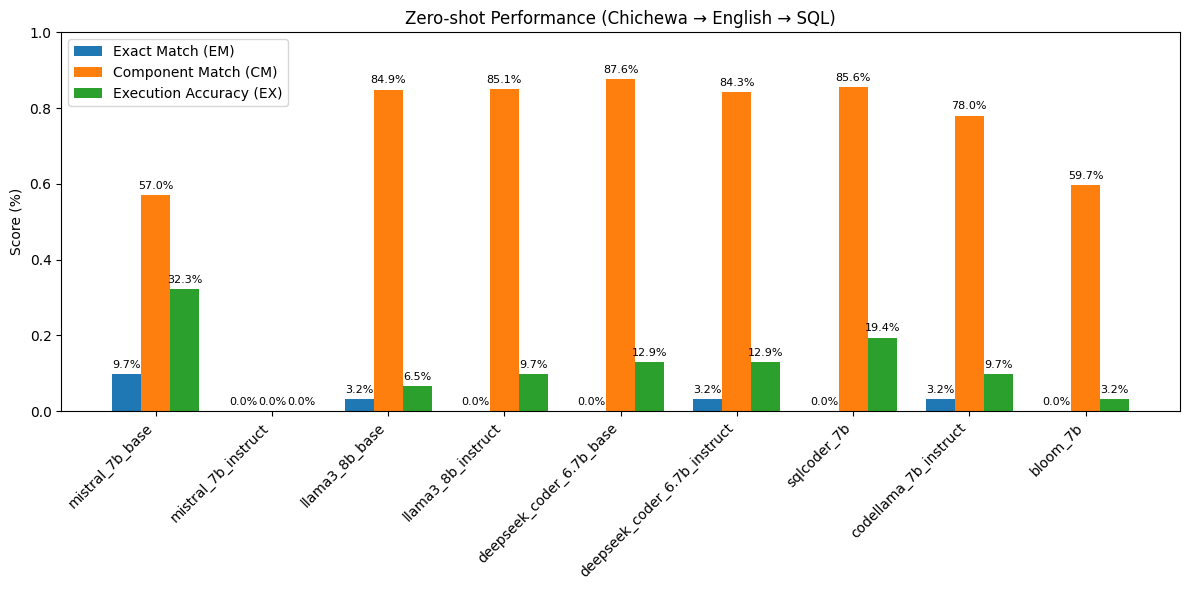

In [ ]:
import matplotlib.pyplot as plt


em = list(df_all_trans.EM.values)  #[0.065, 0.032, 0.032, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cm = list(df_all_trans.CM.values)  #[0.852, 0.781, 0.846, 0.261, 0.0, 0.872, 0.856, 0.860, 0.601]
ea = list(df_all_trans.EX.values)  #[0.097, 0.097, 0.129, 0.097, 0.0, 0.129, 0.129, 0.194, 0.032]

x = range(len(MODELS))
width = 0.25

plt.figure(figsize=(12, 6))
bars_em = plt.bar([i - width for i in x], em, width=width, label="Exact Match (EM)")
bars_cm = plt.bar(x, cm, width=width, label="Component Match (CM)")
bars_ea = plt.bar([i + width for i in x], ea, width=width, label="Execution Accuracy (EX)")

plt.xticks(x, MODELS, rotation=45, ha='right')
plt.ylabel("Score (%)")
plt.title("Zero-shot Performance (Chichewa → English → SQL)")
plt.ylim(0, 1.0)
plt.legend()

# Add percentage labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height*100:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)

add_labels(bars_em)
add_labels(bars_cm)
add_labels(bars_ea)

plt.tight_layout()
plt.show()


# Few Shot Prompt + Retrieval-Augmented Semantic Parsing (RASP)

In [ ]:
# 0.  Prepare deterministic, stratified split  (60 % train / 40 % val)

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import random

# One label per instance so we can stratify by DB
db_labels = [ex["database_name"] for ex in chichewa_val]

train_set, val_set = train_test_split(
    chichewa_val,
    test_size   = 0.40,
    random_state= 42,
    stratify    = db_labels            # keep every DB in both splits
)

print(f"Train set: {len(train_set)}  |  Val set: {len(val_set)}")

# 1.  Re-embed ONLY the training questions (for k-NN retrieval)

embedder    = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
train_texts = [ex["Question_NY"] for ex in train_set]
train_emb   = embedder.encode(train_texts, convert_to_tensor=True, show_progress_bar=True)


# 2.  Retrieval helper now works on the new train_set / train_emb

def get_k_shots(q_chi: str, db_id: str, k: int = 3):
    q_emb = embedder.encode(q_chi, convert_to_tensor=True)
    hits  = util.semantic_search(q_emb, train_emb, top_k=k)[0]

    demos = []
    for h in hits:
        ex = train_set[h["corpus_id"]]
        if ex["database_name"] == db_id:
            demos.append({
                "question": ex["Question_NY"],
                "query":    ex["SQL"],
                "schema":   get_schema_string(db_id),
            })
        if len(demos) == k:
            break
    return demos



def build_retrieved(q_chi: str, schema: str, db_id: str) -> str:
    """
    Few‐shot prompt builder that only uses examples from train_set.
    """
    demos = get_k_shots(q_chi, db_id, k=3)
    parts = ["### Instruction:\nReturn ONE SQL query only, based on the examples.\n"]
    for i, ex in enumerate(demos, 1):
        parts += [
            f"### Example {i} Schema:\n{ex['schema']}",
            f"### Example {i} Question:\n{ex['question']}",
            f"### Example {i} SQL:\n{ex['query']}",
            "### End\n"
        ]
    parts += [
        f"### Database Schema:\n{schema}",
        f"### Question:\n{q_chi}",
        "### SQL:\n"
    ]
    return "\n".join(parts)


BUILDERS = {
    "retr5": build_retrieved,
}


Train set: 18  |  Val set: 13


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# 3 ▪ models (4-bit to keep memory modest even in fp16 env)

MODELS = {
    "mistral_7b_base"              : "mistralai/Mistral-7B-v0.3",
    "mistral_7b_instruct"          : "mistralai/Mistral-7B-Instruct-v0.3",
    "llama3_8b_base"               : "meta-llama/Llama-3.1-8B",
    "llama3_8b_instruct"           : "meta-llama/Llama-3.1-8B-Instruct",
    "deepseek_coder_6.7b_base"     : "deepseek-ai/deepseek-coder-6.7b-base",
    "deepseek_coder_6.7b_instruct" : "deepseek-ai/deepseek-coder-6.7b-instruct",
    "sqlcoder_7b"                  : "defog/sqlcoder-7b-2",
    "codellama_7b_instruct"        : "codellama/CodeLlama-7b-Instruct-hf",
    "bloom_7b"                     : "bigscience/bloomz-7b1-mt"
}

MODELS

{'mistral_7b_base': 'mistralai/Mistral-7B-v0.3',
 'mistral_7b_instruct': 'mistralai/Mistral-7B-Instruct-v0.3',
 'llama3_8b_base': 'meta-llama/Llama-3.1-8B',
 'llama3_8b_instruct': 'meta-llama/Llama-3.1-8B-Instruct',
 'deepseek_coder_6.7b_base': 'deepseek-ai/deepseek-coder-6.7b-base',
 'deepseek_coder_6.7b_instruct': 'deepseek-ai/deepseek-coder-6.7b-instruct',
 'sqlcoder_7b': 'defog/sqlcoder-7b-2',
 'codellama_7b_instruct': 'codellama/CodeLlama-7b-Instruct-hf',
 'bloom_7b': 'bigscience/bloomz-7b1-mt'}

In [ ]:
import warnings
from transformers import logging
import random

logging.set_verbosity_error()
warnings.filterwarnings('ignore')

# global seed (reproducible shuffles, torch, numpy, random, etc.)

import random, numpy as np, torch, os
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#  Update evaluation to run only on test_set

import torch, re, gc, pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

_fence  = re.compile(r"```.*?```", re.S)
_select = re.compile(r"\bselect\b", re.I)
bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")

def load_model(ckpt: str):
    tok = AutoTokenizer.from_pretrained(ckpt, trust_remote_code=True)
    lm  = AutoModelForCausalLM.from_pretrained(
            ckpt, device_map="auto", torch_dtype=torch.float16,
            quantization_config=bnb_cfg,
            trust_remote_code=True).eval()
    return tok, lm

def make_gen(tok, lm, builder_key):
    build_fn = BUILDERS[builder_key]
    @torch.no_grad()
    def _gen(q_chi, db_id):
        schema = get_schema_string(db_id)
        prompt = build_fn(q_chi, schema, db_id)
        ids    = lm.generate(
                     **tok(prompt, return_tensors="pt").to(lm.device),
                     max_new_tokens=128, do_sample=False,
                     eos_token_id=tok.eos_token_id,
                     pad_token_id=tok.eos_token_id
                 )
        txt = tok.decode(ids[0], skip_special_tokens=True)
        txt = _fence.sub("", txt)
        sel = _select.search(txt)
        if not sel:
            return txt.strip()
        frag = txt[sel.start():]
        semi = frag.find(";")
        return " ".join(frag[:semi+1].split()) if semi != -1 else " ".join(frag.split())
    return _gen



# Evaluation strictly on val_set

def eval_model_on_val(gen_fn):
    em = cm = ea = 0
    for ex in tqdm(val_set, desc="Validating"):
        db_id = ex["database_name"]
        pred  = gen_fn(ex["Question_NY"], db_id)

        em += exact_match(pred, ex["SQL"])
        cm += component_match(pred, ex["SQL"])
        ea += int(
            run_query(pred, DB_ROOT / f"{db_id}.sqlite")
            ==
            run_query(ex["SQL"], DB_ROOT / f"{db_id}.sqlite")
        )
    n = len(val_set)
    return em/n, cm/n, ea/n




rows_test = []

for nick, ckpt in MODELS.items():
    print(f"→ Loading {nick}")
    tok, lm = load_model(ckpt)
    gen_fn  = make_gen(tok, lm, "retr5")


    # ── full test‐set metrics ───────────────────────────────────
    em_t, cm_t, ea_t = eval_model_on_val(gen_fn)
    rows_test.append({"model": nick, "EM": em_t, "CM": cm_t, "EX": ea_t})

    del tok, lm
    torch.cuda.empty_cache(); gc.collect()


→ Loading mistral_7b_base


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


→ Loading mistral_7b_instruct


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [00:34<00:00,  2.67s/it]


→ Loading llama3_8b_base


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [01:27<00:00,  6.76s/it]


→ Loading llama3_8b_instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [01:33<00:00,  7.17s/it]


→ Loading deepseek_coder_6.7b_base


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [01:23<00:00,  6.44s/it]


→ Loading deepseek_coder_6.7b_instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [01:28<00:00,  6.83s/it]


→ Loading sqlcoder_7b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [00:28<00:00,  2.23s/it]


→ Loading codellama_7b_instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Validating: 100%|██████████| 13/13 [01:28<00:00,  6.82s/it]


→ Loading bloom_7b


Validating: 100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


In [ ]:
# Quick Sanity Check

tok1, lm1 = load_model(MODELS["mistral_7b_base"])
tok2, lm2 = load_model(MODELS["llama3_8b_instruct"])
tok3, lm3 = load_model(MODELS["sqlcoder_7b"])
tok4, lm4 = load_model(MODELS["bloom_7b"])

gen1 = make_gen(tok1, lm1, "retr5")
gen2 = make_gen(tok2, lm2, "retr5")
gen3 = make_gen(tok3, lm3, "retr5")
gen4 = make_gen(tok4, lm4, "retr5")

sample_ex = val_set[0]
print("Mistral:", gen1(sample_ex["Question_NY"], sample_ex["database_name"]))
print("Llama-3:", gen2(sample_ex["Question_NY"], sample_ex["database_name"]))
print("SQLCoder:", gen3(sample_ex["Question_NY"], sample_ex["database_name"]))
print("Bloom:", gen4(sample_ex["Question_NY"], sample_ex["database_name"]))

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Mistral: SELECT Crop, SUM(Yield) as Total_Yield FROM production GROUP BY Crop ORDER BY Total_Yield DESC LIMIT 1;
Llama-3: SELECT Crop, SUM(Yield) as Total_Yield FROM production GROUP BY Crop ORDER BY Total_Yield DESC LIMIT 1;
SQLCoder: SELECT Crop, SUM(Yield) as Total_Yield FROM production GROUP BY Crop ORDER BY Total_Yield DESC LIMIT 1;
Bloom: SELECT Crop, SUM(Yield) as Total_Yield FROM production GROUP BY Crop ORDER BY Total_Yield DESC LIMIT 1;


In [ ]:
df_test_few_RASP = pd.DataFrame(rows_test).set_index("model").round(3)
print("\n── Few-shot + RASP performance on test_set ──")
display(df_test_few_RASP)

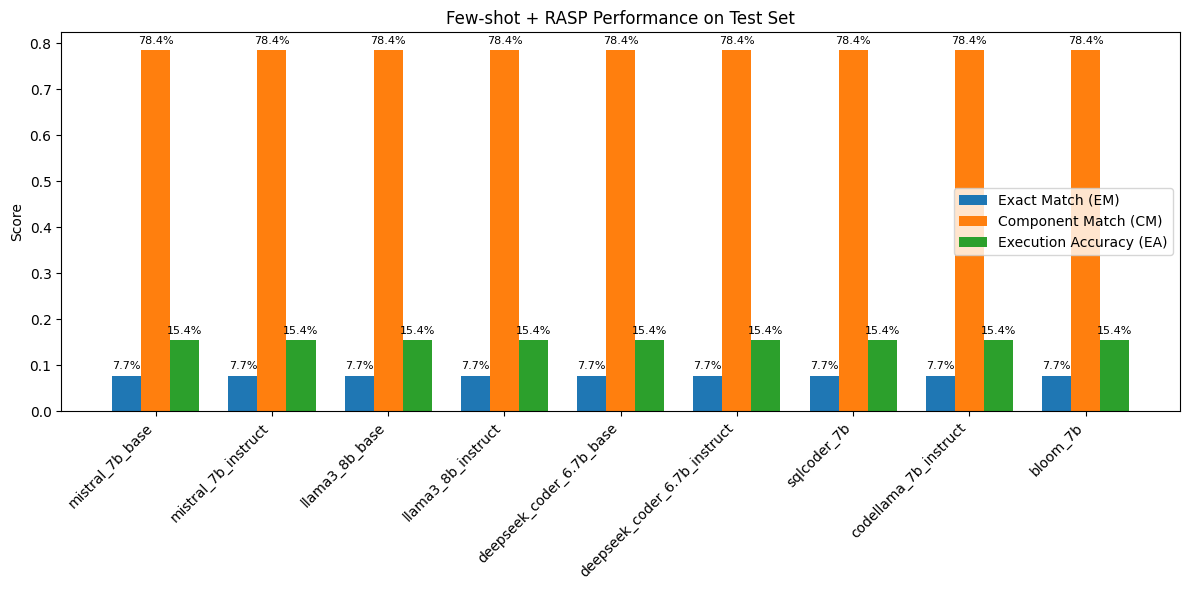

In [ ]:
import matplotlib.pyplot as plt

# Extract data from the dataframe
models = df_test_few_RASP.index.tolist()
em_vals = df_test_few_RASP["EM"].tolist()
cm_vals = df_test_few_RASP["CM"].tolist()
ea_vals = df_test_few_RASP["EX"].tolist()  # assuming 'EX' column holds Execution Accuracy

x = range(len(models))
width = 0.25

plt.figure(figsize=(12, 6))
bars_em = plt.bar([i - width for i in x], em_vals, width=width, label="Exact Match (EM)")
bars_cm = plt.bar(x, cm_vals, width=width, label="Component Match (CM)")
bars_ea = plt.bar([i + width for i in x], ea_vals, width=width, label="Execution Accuracy (EA)")

plt.xticks(x, models, rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Few-shot + RASP Performance on Test Set")
plt.legend()

# Add percentage labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height*100:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)

add_labels(bars_em)
add_labels(bars_cm)
add_labels(bars_ea)

plt.tight_layout()
plt.show()